In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('syn_test.csv')
synid = data['SYN ID']
p_true = data['Injected Period (d)']
p_ls1 = data['LS Period (d)']
rms_ls1 = data['LS Period RMS']
p_ls2 = data['LS 2-term Period (d)']
rms_ls2 = data['LS 2-term Period RMS']
p_acf = data['ACF Period (d)']
rms_acf = data['ACF Period RMS']

In [3]:
noise = [float(synid[i][-5:]) for i in range(len(synid))]

<IPython.core.display.Javascript object>


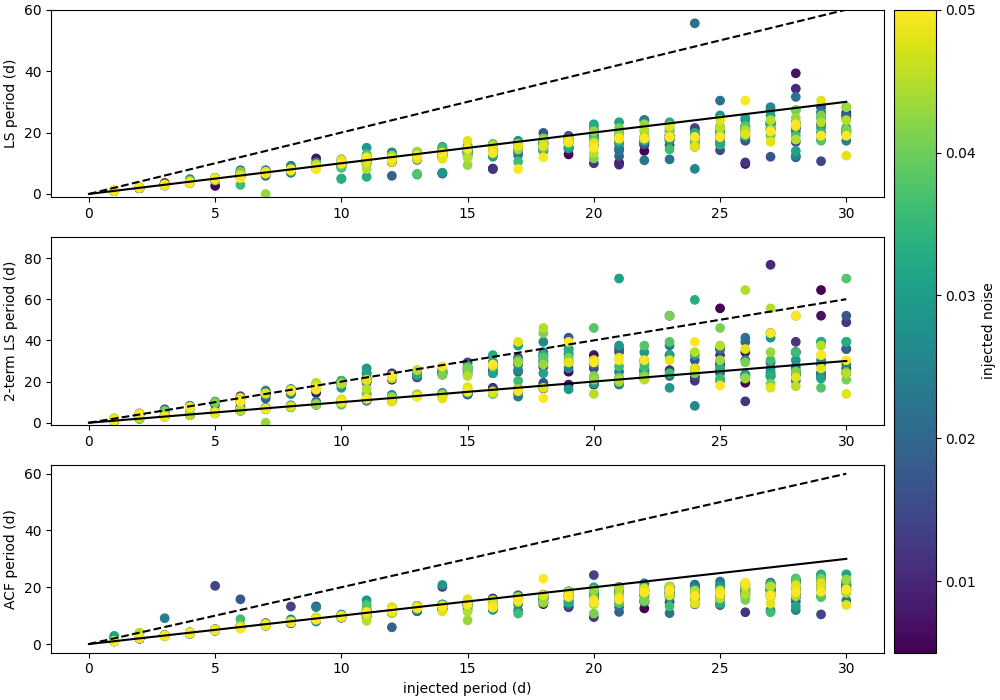

In [4]:
%matplotlib notebook

diag = np.arange(0,31)

mosaic = """
    AD
    BD
    CD
"""
fig, ax = plt.subplot_mosaic(mosaic, gridspec_kw={'width_ratios':[1,0.05]}, constrained_layout=True)

ax['A'].plot(diag, diag, 'k-')
ax['A'].plot(diag, diag*2, 'k--')
crange = ax['A'].scatter(p_true, p_ls1, c=noise)
ax['A'].set(ylabel='LS period (d)', ylim=(-1,60))
# range cut: both LS methods are measuring a period of 1611.0108241076794 for a small number of stars

ax['B'].plot(diag, diag, 'k-')
ax['B'].plot(diag, diag*2, 'k--')
ax['B'].scatter(p_true, p_ls2, c=noise)
ax['B'].set(ylabel='2-term LS period (d)', ylim=(-1,90))

ax['C'].plot(diag, diag, 'k-')
ax['C'].plot(diag, diag*2, 'k--')
ax['C'].scatter(p_true, p_acf, c=noise)
ax['C'].set(xlabel='injected period (d)', ylabel='ACF period (d)')

cbar = plt.colorbar(crange, cax=ax['D'])
cbar.set_label('injected noise')

fig.set_size_inches(10,7)

In [5]:
# testing a simplified version for period only - introduce CDPP as factor later
dist_ls1 = [np.abs(p_t - p_mes)/p_t for p_t, p_mes in zip(p_true, p_ls1)]
dist_ls2 = [np.abs(p_t - p_mes)/p_t for p_t, p_mes in zip(p_true, p_ls2)]
dist_acf = [np.abs(p_t - p_mes)/p_t for p_t, p_mes in zip(p_true, p_acf)]
err_ls1 = np.zeros(30) # periods up to 30 days
err_ls2 = np.zeros(30)
err_acf = np.zeros(30)

index = 0
counter_ls1 = 20 # hacky way to remove outliers; none for acf method
counter_ls2 = 20

for i in range(len(p_true)):
    
    if p_ls1[i] < 100:
        err_ls1[index] += dist_ls1[i]
    else:
        counter_ls1 -= 1
    if p_ls2[i] < 100:
        err_ls2[index] += dist_ls2[i]
    else:
        counter_ls2 -= 1
    err_acf[index] += dist_acf[i]
    
    if i%20 == 0 and i!=0: # there are 20 measurements per period
        err_ls1[index] /= counter_ls1
        counter_ls1 = 20
        err_ls2[index] /= counter_ls2
        counter_ls2 = 20
        err_acf[index] /= 20
        index += 1

In [90]:
np.polyfit(np.arange(1,30), err_acf[:-1], 1)

array([0.0082101, 0.0300939])

In [6]:
line_ls1 = np.poly1d(np.polyfit(np.arange(1,30), err_ls1[:-1], 1))
line_ls2 = np.poly1d(np.polyfit(np.arange(1,30), err_ls2[:-1], 1))
line_acf = np.poly1d(np.polyfit(np.arange(1,30), err_acf[:-1], 1))

<IPython.core.display.Javascript object>


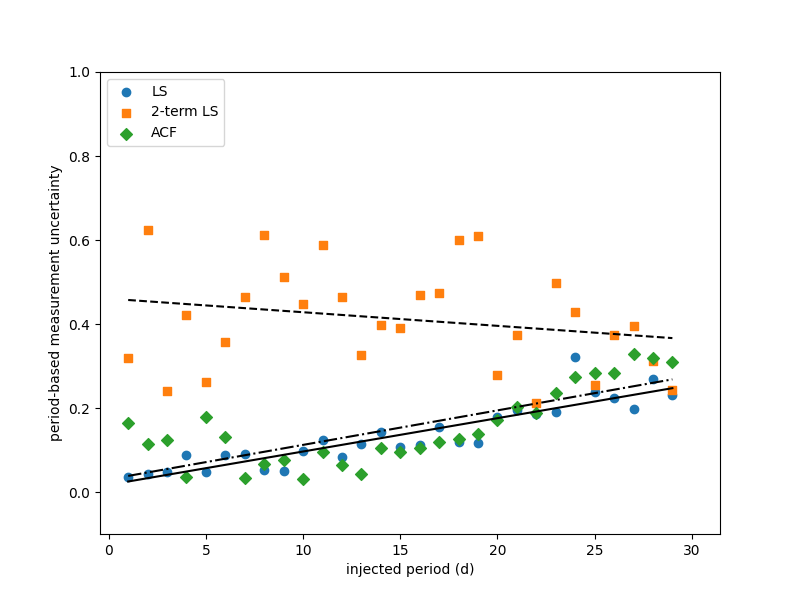

In [7]:
fig, ax = plt.subplots(1)

ax.scatter(np.arange(1,31), err_ls1, label='LS')
ax.scatter(np.arange(1,31), err_ls2, marker='s', label='2-term LS')
ax.scatter(np.arange(1,31), err_acf, marker='D', label='ACF')

ax.plot(np.arange(1,30), line_ls1(np.arange(1,30)), 'k-')
ax.plot(np.arange(1,30), line_ls2(np.arange(1,30)), 'k--')
ax.plot(np.arange(1,30), line_acf(np.arange(1,30)), 'k-.')

ax.set(xlabel='injected period (d)', ylabel='period-based measurement uncertainty', ylim=(-0.1,1))#, yscale='log')
ax.legend(loc='upper left')

fig.set_size_inches(8,6)

# fit line to each series and extrapolate error trend for higher measured periods? or just discard anything over 29d?
# and how does CDPP incorporate into this? is it simpler to do a noise-blind uncertainty?